# Test our method on the NLTT proper motion catalog

In [411]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import const as c
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform, normal
from scipy.optimize import newton
from scipy import stats
from astropy.table import Table
import corner
from scipy.interpolate import interp1d, interp2d
from scipy.stats import gaussian_kde
import pickle


%matplotlib inline

In [412]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t['mu_ra'] = 1.0e3*t['mu_ra']
t['mu_dec'] = 1.0e3*t['mu_dec']
t['mu_ra_err'] = 1.0e3*t['mu_ra_err']
t['mu_dec_err'] = 1.0e3*t['mu_dec_err']

# Set minimum proper motion uncertainties to 1 mas/yr
min_t = np.ones(len(t))
t['mu_ra_err'] = np.max((min_t, t['mu_ra_err']), axis=0)
t['mu_dec_err'] = np.max((min_t, t['mu_dec_err']), axis=0)

In [413]:
print t.colnames
print len(t['ra'])

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'V', 'B', 'R', 'J', 'H', 'K']
36085


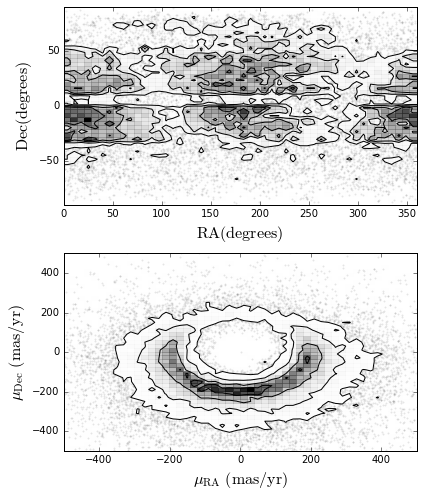

In [415]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':50}
corner.hist2d(t['ra'], t['dec'], range=[(0,360),(-90,90)], ax=ax[0], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec (degrees)}$', size=16)

contourf_kwargs = {'bins':50}
corner.hist2d(t['mu_ra'], t['mu_dec'], range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#corner.hist2d(t['mu_ra']*1.0e3*np.cos(t['dec']*np.pi/180.0), t['mu_dec']*1.0e3, range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#plt.scatter(t['mu_ra'], t['mu_dec'], marker='.', alpha=0.1)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-500,500)
ax[1].set_ylim(-500,500)

#plt.axes().set_aspect('equal')
plt.tight_layout()
#plt.savefig('../figures/rNLTT_pos_mu.pdf')
plt.show()

### Generate set of binaries

In [ ]:
P_binary.generate_binary_set(num_sys=1000000)

### Find probabilities for rNLTT catalog

In [ ]:
length = len(t)
#length = 40
print "We are testing", length, "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('NLTT_1','i4'),('NLTT_2','i4'),('P_random','f8'),('P_binary','f8'),('P_posterior','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length-1):
    
    if i%1000 == 0: print i
    
    star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]

    
    # Random Alignment densities
    pos_density = P_random.get_sigma_pos(star1[0], star1[1], catalog=t, method='kde')
    pm_density = P_random.get_sigma_mu(star1[2], star1[3], catalog=t, method='kde')

    
    prob = np.zeros(len(t)-i-1)
    for j in np.arange(len(t)-i-1)+i+1:

        if t['NLTT'][i] == t['NLTT'][j]:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
        
        delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
        delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
                
        
        prob[j-i-1], P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)
        
    # Get best matching pair
    j = np.argmin(prob)+i+1
    star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]    
    theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
    delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)

    # Only include binary probability if star is within 1 degree
    if theta > 3600.0:
        prob_binary = 0.0
    else:
        delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=100)
        delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=100)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
        prob_binary = 1.0/100 * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['NLTT_1'][i] = t['NLTT'][i]
    prob_out['NLTT_2'][i] = t['NLTT'][j]
    prob_out['P_random'][i] = prob[j-i-1]
    prob_out['P_binary'][i] = prob_binary
    prob_out['P_posterior'][i] = prob_binary / (prob[j-i-1] + prob_binary + 1.0e-99)
    
print "... finished"

In [ ]:
pickle.dump(prob_out, open("../data/rNLTT/prob_out.data", "wb"))

In [222]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
print CG_pairs.colnames

['NLTT-A', 'NLTT-B', 'RAdegA', 'DEdegA', 'RAdegB', 'DEdegB', 'pmRA-A', 'pmDE-A', 'pmRA-B', 'pmDE-B', 'VmagA', '(V-J)A', 'VmagB', '(V-J)B', 'SC-A', 'SC-B', 'CCode', 'Delpm', 'DelSep', 'PosAng', 'Bin', 'Allen']


In [226]:

dtype = [('NLTT_1','i4'),('NLTT_2','i4'),('P_random','f8'),('P_binary','f8'),('P_posterior','f8'),('CCode','i4')]
prob_out_CG = np.array([], dtype=dtype)

for pair in CG_pairs:
    
    if len(prob_out_CG)%100 == 0: print len(prob_out_CG)
    
#    print pair['NLTT-A'], pair['NLTT-B'], pair['CCode']

    # Check if there is a match for star 1
    if len(np.where(pair['NLTT-A'] == t['NLTT'])[0]) == 0:
        continue

    # Check if there is a match for star 2
    if len(np.where(pair['NLTT-B'] == t['NLTT'])[0]) == 0:
        continue

    # Star 1
    star1 = t['ra'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['dec'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_ra'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_dec'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_ra_err'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_dec_err'][np.where(pair['NLTT-A'] == t['NLTT'])][0]

    # Star 2
    star2 = t['ra'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['dec'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_ra'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_dec'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_ra_err'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_dec_err'][np.where(pair['NLTT-B'] == t['NLTT'])][0]

        
    delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
                
        
    # Get probability of random alignment
    prob_random, P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                          catalog=t)

    # Get probability due to true binary
    theta = get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
    delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
    if theta > 3600.0:
        prob_binary = 0.0
    else:
        delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=100)
        delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=100)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
        prob_binary = 1.0/100 * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    prob_temp = np.zeros(1, dtype=dtype)
    prob_temp['NLTT_1'][0] = pair['NLTT-A']
    prob_temp['NLTT_2'][0] = pair['NLTT-B']
    prob_temp['P_random'][0] = prob_random
    prob_temp['P_binary'][0] = prob_binary
    prob_temp['P_posterior'][0] = prob_binary / (prob_random + prob_binary)
    prob_temp['CCode'][0] = pair['CCode']
        
    prob_out_CG = np.append(prob_out_CG, prob_temp[0])

0
100
200
300
400
500
600
700
800
900
1000


In [227]:
pickle.dump(prob_out_CG, open("../data/rNLTT/prob_out_CG.data", "wb"))

In [228]:
print len(prob_out_CG)

1067


In [229]:
pair_CG_accept = prob_out_CG[np.where(prob_out_CG['CCode'] < 4)]
pair_CG_reject = prob_out_CG[np.where(prob_out_CG['CCode'] > 3)]

print "There are", len(pair_GC_accept), "accepted binaries"
print "...and", len(pair_GC_reject), "rejected binaries."

There are 934 accepted binaries
...and 133 rejected binaries.


In [232]:
# Set zero probabilities to some arbitrarily small number
pair_CG_accept['P_random'][np.where(pair_CG_accept['P_random'] == 0.0)] = 1.0e-50
pair_CG_reject['P_random'][np.where(pair_CG_reject['P_random'] == 0.0)] = 1.0e-50
pair_CG_accept['P_binary'][np.where(pair_CG_accept['P_binary'] == 0.0)] = 1.0e-55
pair_CG_reject['P_binary'][np.where(pair_CG_reject['P_binary'] == 0.0)] = 1.0e-55


P_CG_accept = pair_CG_accept['P_binary'] / (pair_CG_accept['P_random'] + pair_CG_accept['P_binary'])
P_CG_reject = pair_CG_reject['P_binary'] / (pair_CG_reject['P_random'] + pair_CG_reject['P_binary'])
P_full = prob_out['P_binary'] / (prob_out['P_binary'] + prob_out['P_random'] + 1.0e-50)
P_full[np.where(np.isnan(P_full))] = 1.0e-50

In [105]:
prob_out = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))

print len(prob_out)

20


In [260]:
print len(prob_out), len(prob_out[np.where(prob_out["P_posterior"] > 0.0)])

36085 1139


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

nbins = 50

# Full posterior
xmin, xmax = -5, 0.5
ax[0].hist(np.log10(P_CG_accept), bins=nbins, histtype='step', color='b', range=[xmin, xmax], label='accepted')
ax[0].hist(np.log10(P_CG_reject), bins=nbins, histtype='step', color='r', range=[xmin, xmax], label='rejected')
ax[0].hist(np.log10(P_full), bins=nbins, histtype='step', color='k', range=[xmin, xmax], label='All pairs')

# ax[0].set_xscale('log')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(0.5, 2000.0)
ax[0].set_yscale('log')
ax[0].set_xlabel('Log Posterior Probability')
ax[0].set_ylabel('N')

ax[0].legend(loc=2)



# P_binary
xmin, xmax = -20, 1.0
ax[1].hist(np.log10(pair_CG_accept['P_binary']), bins=nbins, histtype='step', color='b', range=[xmin, xmax])
ax[1].hist(np.log10(pair_CG_reject['P_binary']), bins=nbins, histtype='step', color='r', range=[xmin, xmax])
ax[1].hist(np.log10(prob_out['P_binary'][np.where(prob_out['P_binary'] > 0.0)]), bins=nbins, histtype='step', color='k', range=[xmin, xmax])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0.0, 100.0)
ax[1].set_xlabel('Log Binary Probability')
ax[1].set_ylabel('N')



# P_random
xmin, xmax = -12,0
ax[2].hist(np.log10(pair_CG_accept['P_random']), bins=nbins, histtype='step', color='b', range=[xmin, xmax])
ax[2].hist(np.log10(pair_CG_reject['P_random']), bins=nbins, histtype='step', color='r', range=[xmin, xmax])
ax[2].hist(np.log10(prob_out['P_random'][np.where(prob_out['P_random'] > 0.0)]), bins=nbins, histtype='step', color='k', range=[xmin, xmax])

ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(0.0, 100.0)
ax[2].set_xlabel('Log Random Alignment Probability')
ax[2].set_ylabel('N')

plt.tight_layout()
plt.savefig('../figures/Prob_CG05.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))


# Plot entire NLTT catalog
ax[0].scatter(prob_out['P_binary'], prob_out['P_random'], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 2)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 3)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=5)
ids = np.where(prob_out_CG['CCode'] > 3)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='c', label='rejected', s=5)

ax[0].set_xlim(1.0e-20, 0.2)
ax[0].set_ylim(1.0e-12, 1.0e-6)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('P(D|binary)')
ax[0].set_ylabel('P(D|random)')
ax[0].legend(loc=3)



# Plot entire NLTT catalog
ax[1].scatter(prob_out['P_binary'], prob_out['P_random'], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 2)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 3)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=5)
ids = np.where(prob_out_CG['CCode'] > 3)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='c', label='Rejected', s=5)

ax[1].set_xlim(1.0e-6, 2.0e-2)
ax[1].set_ylim(1.0e-9, 3.0e-7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('P(D|binary)')






xmin, xmax = 0.01, 1.0
bins=40
# Plot entire NLTT catalog
ax[2].hist(prob_out['P_posterior'], histtype='step', color='k', range=[xmin,xmax], bins=nbins)
# Plot Chaname & Gould (2004) pairs
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 1), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='g', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 2), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='r', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 3), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='b', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] >3), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='c', range=[xmin, xmax], bins=nbins)

ax[2].set_xlim(xmin, xmax)
# ax[1].set_ylim(1.0e-9, 3.0e-7)
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('P(binary|D)')
ax[2].set_ylabel('N')





plt.tight_layout()
#plt.show()

In [ ]:
#print len(np.where(prob_out['P_posterior']>0.5)[0])
#print len(np.where(prob_out['P_posterior']>0.2)[0])

x_ran = np.linspace(0.0001, 1.0, 1000)
y = np.zeros(len(x_ran))
for i in np.arange(len(x_ran)):
    
    y[i] = len(np.where(prob_out['P_posterior']>x_ran[i])[0])
    
plt.plot(x_ran, y, color='k')

plt.ylim(800,1000)

plt.title('rNLTT Catalog Search')
plt.xlabel('Prob limit')
plt.ylabel('N binaries with P(binary|D) > Prob limit')

plt.tight_layout()
plt.savefig('../figures/rNLTT_P_posterior.pdf')
#plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

id_good = np.where(prob_out['P_posterior']>0.5)


# Plot entire NLTT catalog
p_limit = 0.9
x_tmp = np.linspace(1.0e-10, 2.0e-2, 100)
y_tmp = (1.0/p_limit) * (1.0-p_limit)*x_tmp
ax[0,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,0].text(2.0e-8, 1.5e-9, '90%')
ax[0,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,1].text(2.0e-8, 1.5e-9, '90%')
ax[1,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,0].text(2.0e-8, 1.5e-9, '90%')
ax[1,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,1].text(2.0e-8, 1.5e-9, '90%')
p_limit = 0.5
x_tmp = np.linspace(1.0e-10, 2.0e-2, 100)
y_tmp = (1.0/p_limit) * (1.0-p_limit)*x_tmp
ax[0,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,0].text(3.0e-10, 1.5e-9, '50%')
ax[0,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,1].text(3.0e-10, 1.5e-9, '50%')
ax[1,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,0].text(3.0e-10, 1.5e-9, '50%')
ax[1,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,1].text(3.0e-10, 1.5e-9, '50%')


ax[0,0].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2, label='Pairs (P>50%)')
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[0,0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=10)

ax[0,0].set_xlim(1.0e-10, 2.0e-2)
ax[0,0].set_ylim(1.0e-9, 3.0e-7)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('P(D|random)')
ax[0,0].legend(loc=1)



# Plot entire NLTT catalog
ax[1,0].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 2)
ax[1,0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=10)

ax[1,0].set_xlim(1.0e-10, 2.0e-2)
ax[1,0].set_ylim(1.0e-9, 3.0e-7)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('P(D|binary)')
ax[1,0].set_ylabel('P(D|random)')
ax[1,0].legend(loc=1)





# Plot entire NLTT catalog
ax[0,1].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 3)
ax[0,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=10)

ax[0,1].set_xlim(1.0e-10, 2.0e-2)
ax[0,1].set_ylim(1.0e-9, 3.0e-7)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].legend(loc=1)


# Plot entire NLTT catalog
ax[1,1].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 4)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='k', label='Classification', s=10, marker='o')
ids = np.where(prob_out_CG['CCode'] == 5)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='RPM designation', s=10, marker='v')
ids = np.where(prob_out_CG['CCode'] == 6)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label=r'Large $\Delta \mu$', s=10, marker="s")
ids = np.where(prob_out_CG['CCode'] == 7)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Missing star', s=10, marker='*')

ax[1,1].set_xlim(1.0e-10, 1.0)
ax[1,1].set_ylim(1.0e-9, 3.0e-7)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('P(D|binary)')
ax[1,1].set_title('Rejected CG04 matches')
ax[1,1].legend(loc=1)

plt.tight_layout()
plt.savefig('../figures/rNLTT_P_binary_P_random.pdf')
#plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5,8))



ids_matches = np.where(prob_out['P_posterior']>0.5)
ids_NLTT = prob_out['i_1'][ids_matches]


pm = np.sqrt(t['mu_ra'][ids_NLTT]**2 + t['mu_dec'][ids_NLTT]**2)
ax[0].scatter(1.0 - prob_out['P_posterior'][ids_matches], pm, marker='.')
ax[0].set_xlim(0.5, 1.0e-10)
ax[0].set_ylim(100, 1000)
ax[0].set_xscale('log')



pm_err = np.sqrt(t['mu_ra_err'][ids_NLTT]**2 + t['mu_dec_err'][ids_NLTT]**2)
ax[1].scatter(1.0 - prob_out['P_posterior'][ids_matches], pm_err, marker='.')
ax[1].set_xlim(0.5, 1.0e-10)
ax[1].set_ylim(-1, 30)
ax[1].set_xscale('log')


plt.show()
#plt.plot(prob_out['P_posterior'], prob_out)